In [1]:
from dataclasses import dataclass
import timeit
from pathlib import Path
import json

import numpy as np
from numpy.typing import ArrayLike
import matplotlib.pyplot as plt
import scipy.optimize as optimize

import lib.derivative_free_optimizaiton as dfo

In [2]:
!ls ../data/optimization/optimize_requests

100_request.json	     cologne3_request.json
100_shifted_request.json     cologne8_request.json
101_request.json	     grid4x4_request.json
101_shifted_request.json     ingolstadt21_fast_request.json
102_request.json	     ingolstadt21_request.json
102_shifted_request.json     ingolstadt7_fast_request.json
103_request.json	     ingolstadt7_request.json
104_request.json	     novosib_request.json
arterial4x4_0_request.json   single_road_request.json
arterial4x4_30_request.json  sumo_complex_grid_mp_request.json
arterial4x4_59_request.json


In [3]:
# graph_path = "../data/optimization/optimize_requests/100_request.json"
# graph_path = "../data/optimization/optimize_requests/103_request.json"
# graph_path = "../data/optimization/optimize_requests/104_request.json"

# graph_path = "../data/optimization/optimize_requests/single_road_request.json"
# graph_path = "../data/optimization/optimize_requests/sumo_complex_grid_mp_request.json"

# graph_path = "../data/optimization/optimize_requests/arterial4x4_30_request.json"
# graph_path = "../data/optimization/optimize_requests/grid4x4_request.json"
graph_path = "../data/optimization/optimize_requests/cologne8_request.json"
# graph_path = "../data/optimization/optimize_requests/ingolstadt7_fast_request.json"
# graph_path = "../data/optimization/optimize_requests/ingolstadt21_fast_request.json"

graph_path = Path(graph_path)
scenario_name = graph_path.stem

optimization_request = dfo.OptimizeRequestBody.parse_file(graph_path)

# Замена типа ограничений
for prog_bound in optimization_request.programs_bounds:
    prog_bound.mode = dfo.ModeEnum.free

# Ограничения в виде массива
bounds_tuple = []
for prog_bound in optimization_request.programs_bounds:
    for phase in prog_bound.phases:
        bounds_tuple.append((phase.phase_min, phase.phase_max))
bounds = np.array(bounds_tuple)

# Границы гиперкуба ограничений
x_min = bounds[:,0]
x_max = bounds[:,1]


In [399]:
# optimization_request.simulation_time = 120
# optimization_request.dx = 50

# Целевая функция

In [4]:
# cost_func = dfo.AveragedCostFunction(optimization_request)
cost_func = dfo.CostFunction(optimization_request, target=dfo.TargetScore.CritDensityScore)
# cost_func = dfo.CostFunction(optimization_request, target=dfo.TargetScore.OutputCars)

## Сечения

In [5]:

def check_bounds(x, bounds):
    x_min = bounds[:,0]
    x_max = bounds[:,1]
    return (x_min <= x).all() and (x <= x_max).all()

@dataclass
class CostLaneSamples:
    x0: ArrayLike
    direction: ArrayLike
    oc0: float
    cds0: float
    ais0: float
    rs: ArrayLike
    x_vals: ArrayLike
    oc_vals: ArrayLike
    cds_vals: ArrayLike
    ais_vals: ArrayLike


def func_on_direction(cost_func, x0, direction, radius=100, n_ticks=100, bounds=None) -> CostLaneSamples:
    cost_func.drop_hist()
    _ = cost_func(x0)
    oc0 = cost_func.oc_hist[0]
    cds0 = cost_func.cds_hist[0]
    ais0 = cost_func.ais_hist[0] * 3600
    cost_func.drop_hist()

    rs = []
    direction = direction / np.linalg.norm(direction)
    for r in np.linspace(-radius, radius, n_ticks):
        x = x0 + r * direction
        if bounds is not None and check_bounds(x, bounds):
            rs.append(r)
            _ = cost_func(x)

    x_vals = np.array(cost_func.args_hist)
    oc_vals = np.array(cost_func.oc_hist)
    cds_vals = np.array(cost_func.cds_hist)
    ais_vals = np.array(cost_func.ais_hist) * 3600
    cost_func.drop_hist()

    return CostLaneSamples(
        x0=x0,
        direction=direction,
        oc0=oc0,
        cds0=cds0,
        ais0=ais0,
        rs=rs,
        x_vals=x_vals,
        oc_vals=oc_vals,
        cds_vals=cds_vals,
        ais_vals=ais_vals
    )

def plot_samples(cost_func_samples: CostLaneSamples):
    fig, ax = plt.subplots(ncols=3, figsize=(20, 5))
    ax[0].plot(cost_func_samples.rs, cost_func_samples.oc_vals)
    ax[0].scatter([0], [cost_func_samples.oc0], c='g')
    ax[0].grid()
    ax[0].set_title("Число машин, покинувших зону")

    ax[1].plot(cost_func_samples.rs, cost_func_samples.cds_vals)
    ax[1].scatter([0], [cost_func_samples.cds0], c='g')
    ax[1].grid()
    ax[1].set_title("Crit density score")

    ax[2].plot(cost_func_samples.rs, cost_func_samples.ais_vals)
    ax[2].scatter([0], [cost_func_samples.ais0], c='g')
    ax[2].grid()
    ax[2].set_title("Средняя интенсивность")

In [6]:
x00 = (x_min + x_max) / 2
cost_func(x00)

-136.57800100887283

In [7]:
x00 = (x_min + x_max) / 2
direction = np.zeros(len(x_min))
direction[0] = 1.

samples1 = func_on_direction(cost_func, x00, direction, radius=100, bounds=bounds, n_ticks=500)

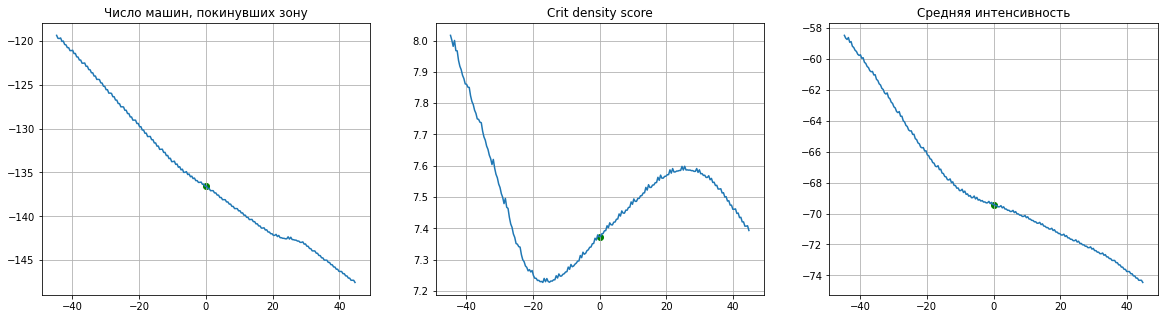

In [8]:
plot_samples(samples1)

In [9]:
x00 = (x_min + x_max) / 2
direction = np.zeros(len(x_min))
direction[1] = 1.

samples2 = func_on_direction(cost_func, x00, direction, radius=100, bounds=bounds, n_ticks=500)

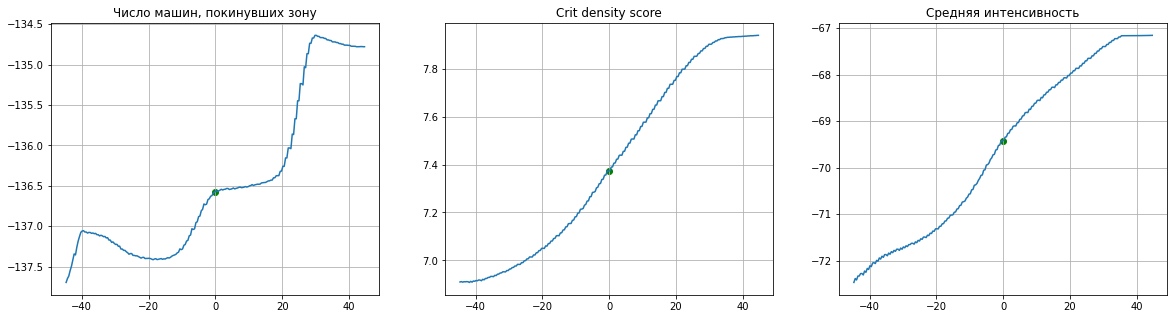

In [10]:
plot_samples(samples2)

In [11]:
x00 = (x_min + x_max) / 2

direction = (x_max - x_min)
samples3 = func_on_direction(cost_func, x00, direction, radius=150, bounds=bounds, n_ticks=500)

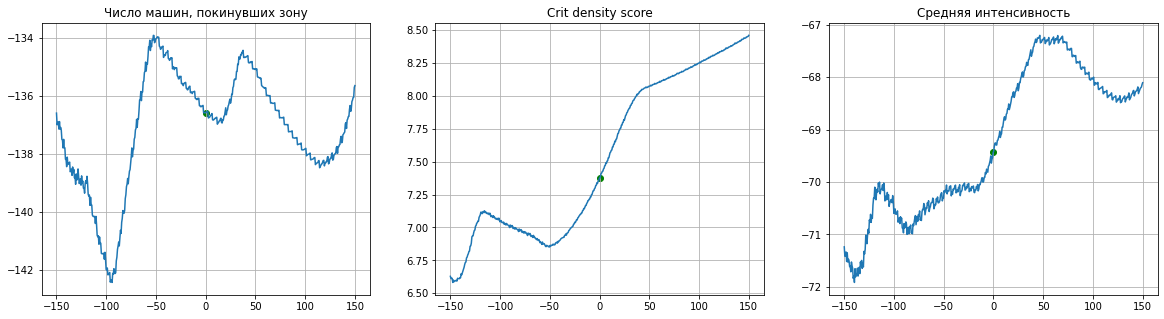

In [12]:
plot_samples(samples3)

In [13]:
print(samples3.x0.shape, samples3.x0)
print(samples3.rs[1])
print(samples3.x_vals[1])

(25,) [55. 55. 55. 55. 55. 55. 55. 55. 55. 55. 55. 55. 55. 55. 55. 55. 55. 55.
 55. 55. 55. 55. 55. 55. 55.]
-149.3987975951904
[25.12024048 25.12024048 25.12024048 25.12024048 25.12024048 25.12024048
 25.12024048 25.12024048 25.12024048 25.12024048 25.12024048 25.12024048
 25.12024048 25.12024048 25.12024048 25.12024048 25.12024048 25.12024048
 25.12024048 25.12024048 25.12024048 25.12024048 25.12024048 25.12024048
 25.12024048]


## Heatmap

In [13]:
def func_on_plane(fun, x0, dx1, dx2, radius=100, n_ticks=100):
    vals = []
    dx1 = dx1 / np.linalg.norm(dx1)
    dx2 = dx2 / np.linalg.norm(dx2)

    for r1 in np.linspace(-radius, radius, n_ticks):
        row_vals = []
        for r2 in np.linspace(-radius, radius, n_ticks):
            x = x0 + r1 * dx1 + r2 * dx2
            row_vals.append(fun(x))
        vals.append(row_vals)
    return np.array(vals)


In [ ]:
x00 = (x_r + x0) / 2
# x00 = x0
# x00 = res.x
f00 = cost_func(x00)

dx1 = (x_r - x_l) / np.linalg.norm(x_r - x_l)
dx2 = np.zeros(len(x_l))
dx2[1] = 1.

heatmap = func_on_plane(cost_func, x00, dx1, dx2, radius=10)

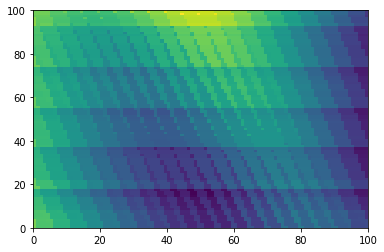

In [ ]:
plt.pcolormesh(heatmap)

# Оптимизация

### Вспомогательные методы

In [14]:
def plot_convergence(cost_func: dfo.CostFunction):
    fig, ax = plt.subplots(ncols=3, figsize=(20, 5))
    ax[0].plot(cost_func.oc_hist)
    # ax[0].scatter([0], [cost_func_samples.oc0], c='g')
    ax[0].grid()
    ax[0].set_title("Число машин, покинувших зону")

    ax[1].plot(cost_func.cds_hist)
    # ax[1].scatter([0], [cost_func_samples.cds0], c='g')
    ax[1].grid()
    ax[1].set_title("Crit density score")

    ais_hist = np.array(cost_func.ais_hist) * 3600
    ax[2].plot(ais_hist)
    # ax[2].scatter([0], [cost_func_samples.ais0], c='g')
    ax[2].grid()
    ax[2].set_title("Средняя интенсивность")

In [15]:
class OptimizationTimeout(Exception):
    def __init__(self, xk: ArrayLike):
        self.x = xk

class TimeoutCallback:
    def __init__(self, max_duration: float):
        self.start = timeit.default_timer()
        self.max_duration = max_duration

    def __call__(self, xk: ArrayLike) -> bool:
        curr_time = timeit.default_timer()
        if (curr_time - self.start) > self.max_duration:
            raise OptimizationTimeout(xk)

## Nelder-Mead

In [183]:
init_plan = cost_func.optimization_request.plan
x0 = cost_func.plan_to_params(init_plan)
print(len(x0), x0)

25 [36.0, 9.0, 36.0, 9.0, 42.171265111758544, 33.99647503833608, 54.17575443674565, 14.812518665839832, 46.98993094541993, 26.76558304419674, 10.211648835652491, 29.58169667576485, 12.10405076249128, 30.327307002018618, 17.532336514152874, 48.188250069410984, 86.27307584656424, 11.37726719620455, 34.328899976600816, 11.077700755620386, 49.37452419876308, 39.17719699853644, 14.9722040355854, 32.982774224058, 16.428676236724666]


In [184]:
init_simplex = [x0]
for i in range(len(x0)):
    plan = cost_func.sample_plan()
    xi = cost_func.plan_to_params(plan)
    init_simplex.append(xi)
init_simplex = np.array(init_simplex)

In [185]:
init_simplex.shape

(26, 25)

In [186]:
cost_func.drop_hist()
try:
    res = optimize.minimize(
        lambda x: cost_func(x),
        x0,
        method="Nelder-Mead",
        bounds=bounds,
        options={
            'adaptive': True,
            'xatol': 0.9,
            'initial_simplex': init_simplex,
        },
        # callback=TimeoutCallback(max_duration=150)
    )
except OptimizationTimeout as err:
    res = err

print(res.x)

/tmp/ipykernel_10252/2753734318.py:3: OptimizeWarning: Initial guess is not within the specified bounds
  res = optimize.minimize(


[62.86532748 24.73068962 26.2945877  10.61226761 20.23496414 30.01714485
 32.46984497 45.13750895 20.14437985 59.82934264 30.16563397 35.26108651
 22.04279048 67.55429205 14.09907929 84.98011555 86.48359458 33.33920091
 43.44659926 15.71468623 36.49444649 51.97215516 31.78306859 59.87669693
 22.86993203]


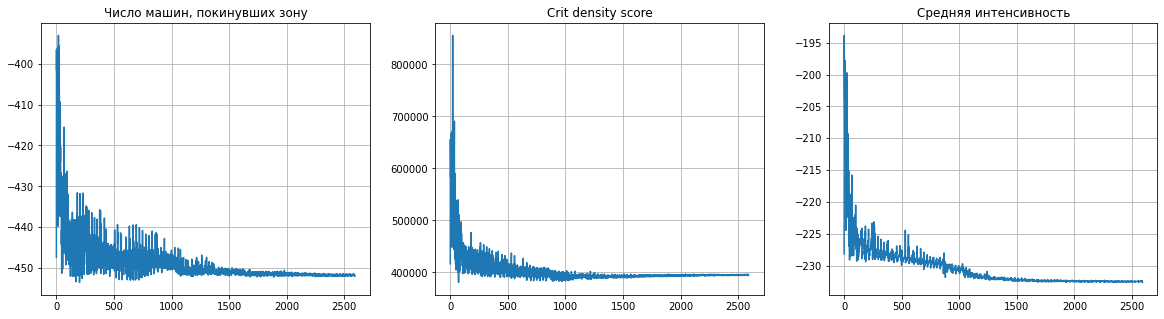

In [187]:
plot_convergence(cost_func)

## Powell

In [19]:
cost_func.drop_hist()
try:
    res = optimize.minimize(
        lambda x: cost_func(x),
        x0,
        method="Powell",
        bounds=bounds,
        # options={
        #     'adaptive': True,
        #     'xatol': 0.9,
        #     'initial_simplex': init_simplex,
        # },
        # callback=TimeoutCallback(max_duration=20)
    )
except OptimizationTimeout as err:
    res = err
print(res.x)

/tmp/ipykernel_10252/684726222.py:3: OptimizeWarning: Initial guess is not within the specified bounds
  res = optimize.minimize(


[66.82950001 10.7318134  11.32621114 10.7318173  10.93372224 11.91582555
 73.59859301 66.93361935 65.62310858 92.31893881 10.30194919 24.00165085
 31.24617622 86.86921139 30.0931917  22.94064672 65.62310335 10.54405726
 25.76556851 37.91585521 36.00818557 15.75065475 11.55042601 65.62311997
 58.55052766]


Text(0.5, 1.0, 'Средняя интенсивность')

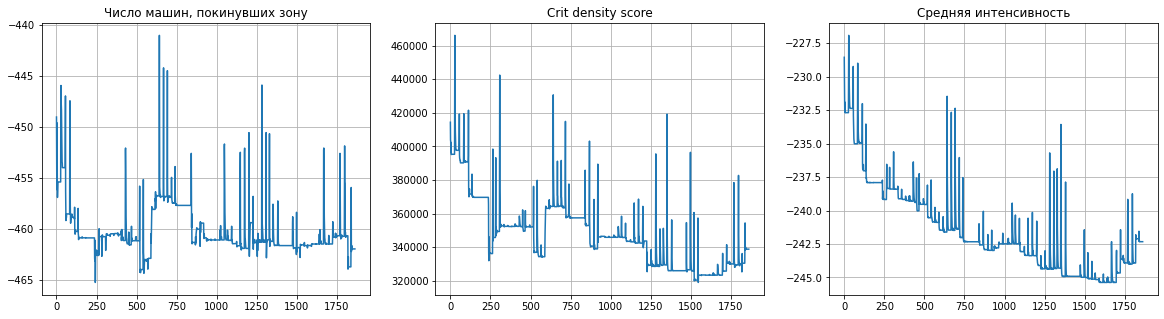

In [20]:
plot_convergence(cost_func)

## Trust region (trust-constr)

In [27]:
cost_func.drop_hist()
res = optimize.minimize(
    cost_func,
    x0,
    method="trust-constr",
    bounds=bounds,
    # options={
    #     'adaptive': True,
    #     'xatol': 0.9,
    #     'initial_simplex': init_simplex,
    # },
    # callback=TimeoutCallback(max_duration=20)
)
print(res.x)

/home/matrosik/voice_link/asudd-macro-rust/venv/lib/python3.9/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '


[35.99520856 10.00108772 35.99520856 10.00108772 42.16787668 33.99127959
 54.17552837 14.80914026 46.98776562 26.75920535 10.3607083  29.57572139
 12.13797903 30.32145166 17.52599325 48.18640117 86.27977454 11.48013046
 34.32376957 11.24485624 49.37299212 39.17310073 14.96844696 32.97738559
 16.42294468]


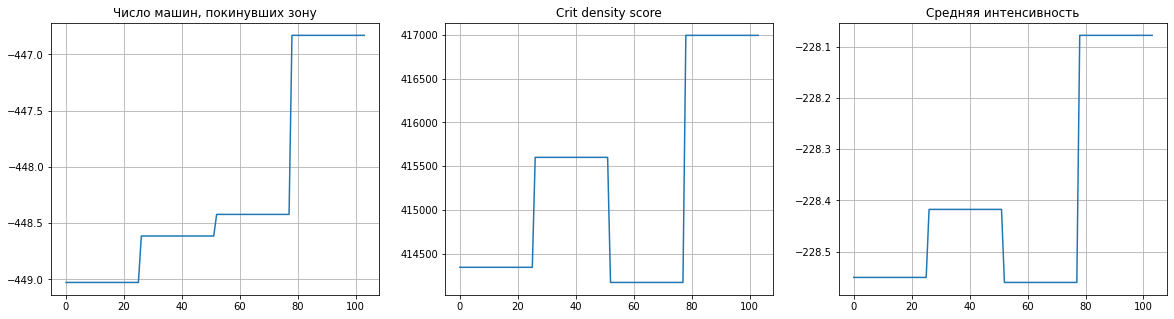

In [30]:
plot_convergence(cost_func)

## COBYLA

In [31]:
cost_func.drop_hist()
res = optimize.minimize(
    cost_func,
    x0,
    method="COBYLA",
    bounds=bounds,
    # options={
    #     'adaptive': True,
    #     'xatol': 0.9,
    #     'initial_simplex': init_simplex,
    # },
    # callback=TimeoutCallback(max_duration=20)
)
print(res.x)

/home/matrosik/voice_link/asudd-macro-rust/venv/lib/python3.9/site-packages/scipy/optimize/_minimize.py:572: RuntimeWarning: Method COBYLA cannot handle bounds.
  warn('Method %s cannot handle bounds.' % method,


[39.94801625  7.13602756 34.64030446  6.45180547 40.84035501 31.31564577
 55.61014928 14.55463104 46.45966903 23.54217415  7.10388475 27.72355299
 11.04986187 29.43701471 17.56824962 47.45468775 84.76654409  7.42719928
 36.00379026 11.77749151 49.24269739 40.73984779 14.60012361 32.46045413
 17.44260564]


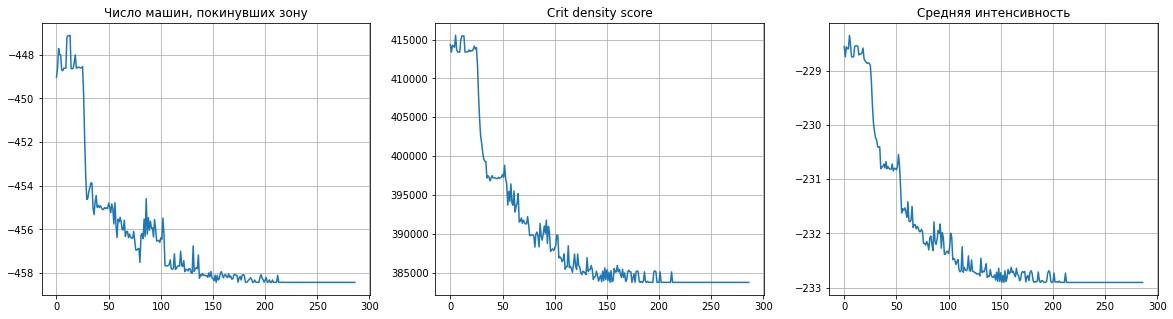

In [32]:
plot_convergence(cost_func)

## DIRECT

In [10]:
cost_func.drop_hist()
res = optimize.direct(
    cost_func,
    bounds=bounds_tuple
)
print(res.x)

[10.18518519 98.33333333 99.44444444 10.55555556]


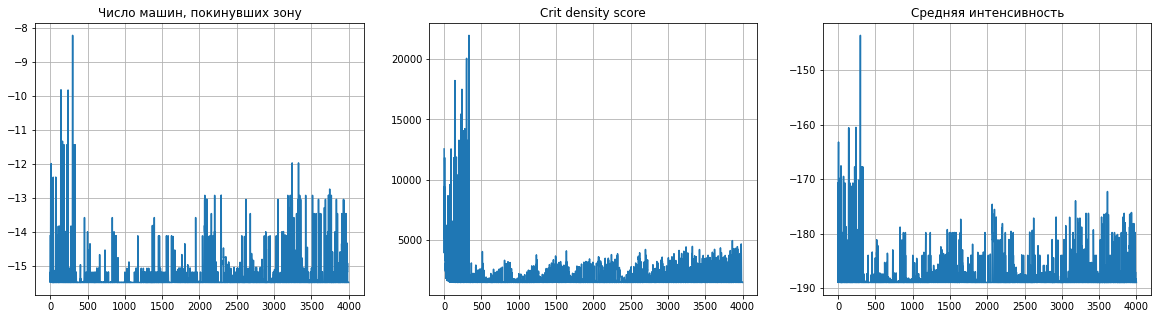

In [11]:
plot_convergence(cost_func)

In [12]:
cost_func.best_target

1448.0656167401337

In [13]:
cost_func.best_x

[10.185185185185187, 98.33333333333333, 99.44444444444444, 10.555555555555557]

In [15]:
cost_func([10., 100., 100., 10.])

1452.8476453073058

## Dual Annealing

In [26]:
cost_func.drop_hist()
res = optimize.dual_annealing(
    cost_func,
    bounds=bounds_tuple
)
print(res.x)

{
    "simulation_time": 300,
    "dx": 20.0,
    "graph": {
        "vertices": [
            {
                "chain_id": 1,
                "length": 22.36
            },
            {
                "chain_id": 2,
                "length": 36.5
            },
            {
                "chain_id": 3,
                "length": 83.37
            },
            {
                "chain_id": 4,
                "length": 82.25
            },
            {
                "chain_id": 5,
                "length": 159.69
            },
            {
                "chain_id": 6,
                "length": 159.69
            },
            {
                "chain_id": 7,
                "length": 188.11
            },
            {
                "chain_id": 8,
                "length": 188.11
            },
            {
                "chain_id": 9,
                "length": 144.74
            },
            {
                "chain_id": 10,
                "length": 144.74
      

KeyboardInterrupt: 

In [ ]:
plot_convergence(cost_func)

## Smoothing scheme

In [16]:
import torch
import torch.optim
import torch.nn as nn
import torch.optim.lr_scheduler as lr_scheduler
from botorch.utils.sampling import sample_hypersphere

In [17]:
def stoch_grad(cost_func, x, tau, e, dim):
    x1 = x - tau * e
    x2 = x + tau * e
    f1 = cost_func(x1[0])
    f2 = cost_func(x2[0])
    return (dim / (2 * tau)) * (f2 - f1) * e

In [42]:
x0 = cost_func.plan_to_params(cost_func.optimization_request.plan)
# x0 = x_min
x = torch.tensor(x0)
x = nn.Parameter(x)
print(x)

Parameter containing:
tensor([25.2666, 13.7574, 15.9363, 15.1629, 19.4379, 33.4827, 19.6373, 33.1604,
        55.7841, 31.2972, 25.4389, 55.8495, 11.6799, 30.6744, 18.4350, 22.6278,
        65.9506, 19.4497, 60.4911, 17.8534, 66.2257, 38.2409, 16.1497, 16.4936,
        29.9223], requires_grad=True)


In [43]:
np.linalg.norm(x_max - x_min)

450.0

In [44]:
cost_func.drop_hist()
x = torch.tensor(x0)
x = nn.Parameter(x)

# eps = 0.1
# M2 = 11. / 2

# n_steps = 250
n_steps = 100
batch_size = 5
dim = x.shape[0]
# tau = 2.0
# tau = 1.5
tau = 3.
# tau = 0.5
# tau = 0.1
# tau = eps / (2 * M2)

lr = 5.
# lr = 0.01

# R = np.linalg.norm(x_max - x_min) / 4
# n_steps = int(np.power(dim, 0.25) * M2 * R / eps)
# print(f"n_steps = {n_steps}")

# optimizer = torch.optim.SGD([x], lr=350.)
optimizer = torch.optim.Adam([x], lr=lr)
scheduler = lr_scheduler.MultiplicativeLR(optimizer, lr_lambda=lambda l: 0.99)

x_min_tensor = torch.tensor(x_min)
x_max_tensor = torch.tensor(x_max)

start_time = timeit.default_timer()
for i in range(n_steps):
    optimizer.zero_grad()
    g = torch.zeros_like(x)
    for _ in range(batch_size):
        e = sample_hypersphere(d=dim)
        g_tmp = stoch_grad(cost_func, x, tau, e, dim)
        g += g_tmp[0]
    g /= batch_size
    x.grad = g
    optimizer.step()
    scheduler.step()
    with torch.no_grad():
        x.clamp_(x_min_tensor, x_max_tensor)

duration = timeit.default_timer() - start_time

result = {
    "scenario": scenario_name,
    "optimization_duration": duration,
    "n_steps": n_steps,
    "batch_size": batch_size,
    "tau": tau,
    "lr": lr,
    "best_target": cost_func.best_target,
    # "best_arg": cost_func.best_x.detach().numpy(),
    "oc_hist": cost_func.oc_hist,
    "cds_hist": cost_func.cds_hist,
    "ais_hist": cost_func.ais_hist,
}

In [45]:
print(x)

Parameter containing:
tensor([56.4373, 10.0000, 10.0000, 10.0000, 20.2753, 55.8724, 45.9009, 58.1304,
        61.9693, 68.3110, 12.8853, 44.4202, 11.9671, 70.1271, 10.5361, 82.4953,
        61.8400, 45.2034, 32.5015, 19.1243, 78.3994, 31.1641, 18.8838, 59.8133,
        28.9779], requires_grad=True)


In [46]:
cost_func.best_target

-170.72026194181944

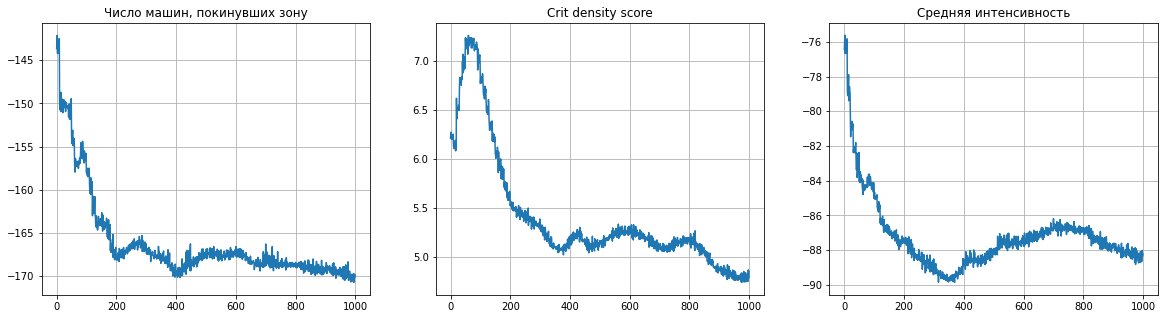

In [48]:
plot_convergence(cost_func)
# bsize = 5, tau = 0.5, lr = 0.1

In [386]:
def save_optimization_result(result):
    scenario_name = result['scenario']
    scenario_dir_path = Path(f"tmp/{scenario_name}")
    if not scenario_dir_path.exists():
        scenario_dir_path.mkdir()
    
    count = len(list(scenario_dir_path.iterdir()))
    result_path = scenario_dir_path / f"{scenario_name}_{count}.json"
    with open(result_path, 'w') as file:
        json.dump(result, file)
        

def plot_optimization_result(result):
    fig, ax = plt.subplots(ncols=3, figsize=(20, 5))
    fig.suptitle(f"{result['scenario']}: n_steps = {result['n_steps']}, batch_size = {result['batch_size']}, tau = {result['tau']}, lr = {result['lr']}")

    ax[0].plot(result['oc_hist'])
    # ax[0].scatter([0], [cost_func_samples.oc0], c='g')
    ax[0].grid()
    ax[0].set_title("Число машин, покинувших зону")

    ax[1].plot(result['cds_hist'])
    # ax[1].scatter([0], [cost_func_samples.cds0], c='g')
    ax[1].grid()
    ax[1].set_title("Crit density score")

    ais_hist = np.array(result['ais_hist']) * 3600
    ax[2].plot(ais_hist)
    # ax[2].scatter([0], [cost_func_samples.ais0], c='g')
    ax[2].grid()
    ax[2].set_title("Средняя интенсивность")

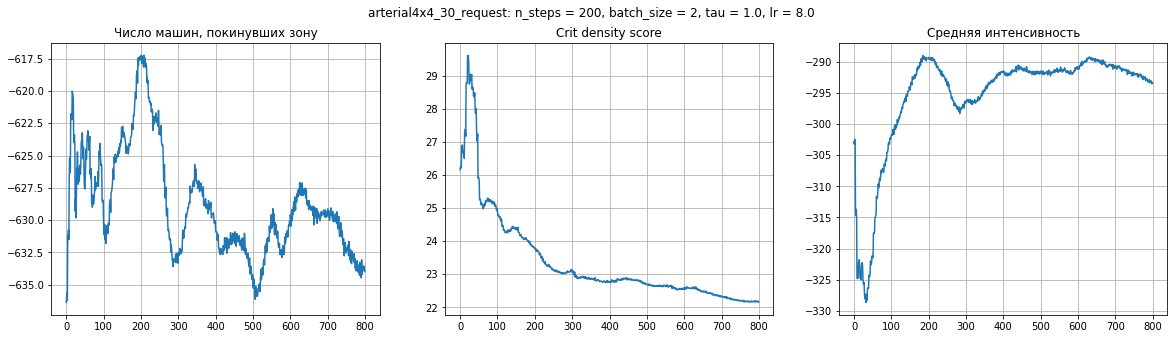

In [387]:
plot_optimization_result(result)

In [286]:
save_optimization_result(result)

In [31]:
cost_func.best_target

3.974308469983779

In [23]:
cost_func.best_x

tensor([55.0877,  9.9265, 10.0077,  9.8303, 16.3328, 29.7027, 47.3223, 24.3934,
        37.6045, 35.5991,  9.9661,  9.9308,  9.8038, 36.9757, 16.2831, 61.5026,
        86.8937,  9.6665, 20.0952, 10.1476, 52.4539, 12.0258, 10.0254, 26.9001,
        13.4033], grad_fn=<SelectBackward0>)